In [ ]:
!pip install easyocr pytesseract
!apt-get install -y tesseract-ocr-rus
!tesseract --list-langs


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-rus is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
List of available languages (3):
eng
osd
rus


In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import easyocr
import pytesseract
from PIL import Image

def remove_black_lines_and_fix_symbols(image_path):
    # Загрузка изображения и преобразование в HSV
    img = cv2.imread(image_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Настройка диапазона для синего и голубого цветов
    lower_blue = np.array([85, 30, 50])
    upper_blue = np.array([135, 255, 255])

    # Создание маски и выделение синего текста
    blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Морфологическая операция (расширение), чтобы устранить разрывы
    kernel = np.ones((3, 3), np.uint8)  # Настройка ядра (размер можно подбирать)
    blue_mask_dilated = cv2.dilate(blue_mask, kernel, iterations=25)  # Расширение маски
    # Применение маски к изображению
    result = cv2.bitwise_and(img, img, mask=blue_mask_dilated)

    # Замена чёрного фона на белый
    result[blue_mask_dilated == 0] = [255, 255, 255]

    # Сохраняем результат рядом с исходным файлом
    processed_image_path = image_path.replace(".jpg", "_processed.jpg")
    cv2.imwrite(processed_image_path, result)

    return processed_image_path

Текст: м, Доверие: 0.4334957390534022
Распознанный текст: 


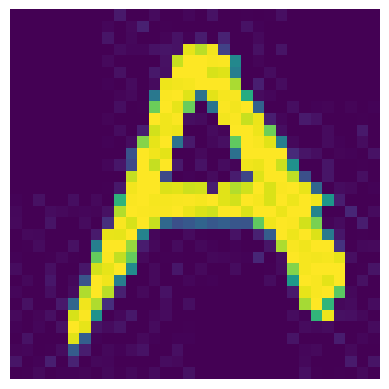

In [ ]:
image_path_new = "image.jpg"  # Путь к загруженному изображения

#image_path_new=remove_black_lines(image_path)

reader = easyocr.Reader(['ru'])  # Добавляем поддержку русского языков
# Распознаём текст на изображении
results = reader.readtext(image_path_new,allowlist="йцукенгшщзхъфывапролджэячсмитьбюё")  # detail=1 вернёт координаты и текст
# Выводим текст и координаты
for (bbox, text, confidence) in results:
    print(f"Текст: {text}, Доверие: {confidence}")


img = cv2.imread(image_path_new)
custom_config = r'-c tessedit_char_whitelist=йцукенгшщзхъфывапролджэячсмитьбюё'
text = pytesseract.image_to_string(img, lang="rus", config=custom_config)
print("Распознанный текст:", text)

img = Image.open(image_path_new)
plt.imshow(img)
plt.axis("off")
plt.show()


In [ ]:
from graphviz import Digraph

# Создание UML диаграммы прецедентов
dot = Digraph('UserScenario', format='png')

# Определение актера (Пользователь)
dot.node('U', 'Пользователь', shape='actor')

# Определение прецедентов (функций системы)
dot.node('P1', 'Загрузить PDF', shape='ellipse')
dot.node('P2', 'Обработать документ', shape='ellipse')
dot.node('P3', 'Выделить ошибки', shape='ellipse')
dot.node('P4', 'Сравнить ФИО с базой', shape='ellipse')
dot.node('P5', 'Редактировать данные', shape='ellipse')
dot.node('P6', 'Экспортировать в XLS', shape='ellipse')

# Связи между актором и прецедентами
dot.edge('U', 'P1')
dot.edge('P1', 'P2')
dot.edge('P2', 'P3')
dot.edge('P3', 'P4')
dot.edge('P4', 'P5')
dot.edge('P2', 'P6')
dot.edge('P5', 'P6')

# Сохранение диаграммы
diagram_path = "/mnt/data/user_scenario_uml.png"
dot.render(diagram_path, format='png')

# Отображение диаграммы пользователю
import IPython.display as display
display.Image(diagram_path)


In [ ]:
Текстовая ячейка <WEYXFOjaiJ6W>
# %% [markdown]
# Transformers for letters recognition
Fine-tuning of ViT and BEiT for handwritten letters recognition.

Текстовая ячейка <3qk31iFpmXFL>
# %% [markdown]
About:

1. [ViT paper](https://arxiv.org/pdf/2010.11929.pdf), [ViT Github](https://github.com/google-research/vision_transformer), [ViT on huggingface🤗](https://huggingface.co/docs/transformers/model_doc/vit)
2. [BEiT paper](https://openreview.net/pdf?id=p-BhZSz59o4), [BEiT on huggingface🤗](https://huggingface.co/docs/transformers/model_doc/beit)


Текстовая ячейка <1rQBn4g9tCWC>
# %% [markdown]
This notebook is based on huggingface🤗 [tutorial](https://huggingface.co/blog/fine-tune-vit) for ViT fine-tuning

Текстовая ячейка <jJklyKNKijPs>
# %% [markdown]
## Imports

Кодовая ячейка <Qh2R9NFcmrWT>
# %% [code]
!pip3 install transformers tokenizers datasets evaluate --quiet
Получены выходные данные.
0KB
	Stream
		'pip3' is not recognized as an internal or external command,
		operable program or batch file.

Кодовая ячейка <nDzb1u4ghzgo>
# %% [code]
import os
import random
import warnings
import google-api-python-client

import zipfile
from google.colab import drive

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm, trange

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from PIL import Image

import datasets
from datasets import load_dataset, ClassLabel

from transformers import ViTFeatureExtractor, BeitFeatureExtractor
from transformers import ViTForImageClassification, BeitForImageClassification
from transformers import TrainingArguments, Trainer
from transformers import pipeline

import evaluate

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader


warnings.filterwarnings("ignore")
%matplotlib inline
Получены выходные данные.
0KB
	Error
		SyntaxError
		  Cell In[16], line 4
		    import google-api-python-client
		                 ^
		SyntaxError: invalid syntax


Кодовая ячейка <62xEDJmeikkl>
# %% [code]
drive.mount('/content/drive')
Получены выходные данные.
0KB
	Stream
		Mounted at /content/drive

Кодовая ячейка <OzGgQmNWinHY>
# %% [code]
path_to_zip_file = '/content/drive/MyDrive/total dict.zip'
directory_to_extract_to = '/content/data'

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

Кодовая ячейка <QZABgTv2ioi5>
# %% [code]
!cp '/content/drive/MyDrive/full_dict/total dict/all_by_words.tsv' '/content/data/total dict'

Кодовая ячейка <WXj6cxkWiqpn>
# %% [code]
os.chdir('/content/data/total dict')
os.path.abspath('.')
Получены выходные данные.
0KB
	text/plain
		'/content/data/total dict'

Кодовая ячейка <BJ5jLI6wslc8>
# %% [code]
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

Кодовая ячейка <2Nz4ayH8vms8>
# %% [code]
accuracy = evaluate.load('accuracy', 'multiclass')
Получены выходные данные.
0KB
	text/plain
		Downloading builder script:   0%|          | 0.00/4.20k [00:00<?, ?B/s]

Кодовая ячейка <eMhT-QwvirDP>
# %% [code]
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False

Кодовая ячейка <GuD88Uk0itG7>
# %% [code]
seed_everything()

Текстовая ячейка <5YVAv78Vip2J>
# %% [markdown]
## Data

Кодовая ячейка <9QvxaqrvNpdh>
# %% [code]
!cp '/content/drive/MyDrive/full_dict/total dict/all_files_new.tsv' '/content/data/total dict'

Кодовая ячейка <0hA1uYb0Na4r>
# %% [code]
df = pd.read_csv('/content/drive/MyDrive/all_files_final.csv', delimiter=',')
line_name = "/content/data/total dict"
full_paths = [line_name + path[1:] for path in df["new_path"]]
df["new_path"] = full_paths
df = df.dropna(subset=['letter'])
df.head()
Получены выходные данные.
6KB
	text/plain
		Unnamed: 0  letter_position   category letter  \
		0           0                0  codewords      а
		1           1                2  codewords      а
		2           2                4  codewords      а
		3           3                1  codewords      б
		4           4                3  codewords      к

		                                            new_path  word_id word_true
		0  /content/data/total dict/codewords/abakan.jpg_...        0    абакан
		1  /content/data/total dict/codewords/abakan.jpg_...        0    абакан
		2  /content/data/total dict/codewords/abakan.jpg_...        0    абакан
		3  /content/data/total dict/codewords/abakan.jpg_...        0    абакан
		4  /content/data/total dict/codewords/abakan.jpg_...        0    абакан

Текстовая ячейка <SroCScWoViMr>
# %% [markdown]
[Issue](https://github.com/huggingface/transformers/issues/21638) on sizes of images. Let's use the ```PIL``` to open images. Then convert it to RGB according to [this duscussion](https://stackoverflow.com/questions/75168665/unsupported-number-of-image-dimensions-while-using-image-utils-from-transforme)

Кодовая ячейка <Oq49ZVuisgWK>
# %% [code]
class LettersDataset(Dataset):
    def __init__(self, data, feature_extractor, transform=None):
        self.data = data
        self.transform = transform
        self.feature_extractor = feature_extractor

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx].new_path
        # print(img_path)
        image = Image.open(img_path)
        # print(image)
        label = self.data.iloc[idx].labels
        if self.transform:
            item = self.transform(image, label, self.feature_extractor)
            return item

        return image, label

Кодовая ячейка <ler4EUg5IPi7>
# %% [code]
le = preprocessing.LabelEncoder()
df['labels'] = le.fit_transform(df.letter)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

Кодовая ячейка <m9_WEJTiuwC4>
# %% [code]
df.head()
Получены выходные данные.
6KB
	text/plain
		Unnamed: 0  letter_position   category letter  \
		0           0                0  codewords      а
		1           1                2  codewords      а
		2           2                4  codewords      а
		3           3                1  codewords      б
		4           4                3  codewords      к

		                                            new_path  word_id word_true  \
		0  /content/data/total dict/codewords/abakan.jpg_...        0    абакан
		1  /content/data/total dict/codewords/abakan.jpg_...        0    абакан
		2  /content/data/total dict/codewords/abakan.jpg_...        0    абакан
		3  /content/data/total dict/codewords/abakan.jpg_...        0    абакан
		4  /content/data/total dict/codewords/abakan.jpg_...        0    абакан

		   labels
		0       1
		1       1
		2       1
		3       2
		4      11

Кодовая ячейка <1Qsr81dJuz9K>
# %% [code]
le.classes_
Получены выходные данные.
0KB
	Error
		NameError
		---------------------------------------------------------------------------
		NameError                                 Traceback (most recent call last)
		Cell In[2], line 1
		----> 1 le.classes_

		NameError: name 'le' is not defined

Текстовая ячейка <kUESNAU9jIMC>
# %% [markdown]
## ViT Model

Кодовая ячейка <d23a8Z2psiHG>
# %% [code]
vit_model_name = 'google/vit-base-patch16-224'
vit_feature_extractor = ViTFeatureExtractor.from_pretrained(vit_model_name)
Получены выходные данные.
0KB
	text/plain
		Downloading (…)rocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Кодовая ячейка <cVYMjqnNAj_I>
# %% [code]
def process_example(image, label, feature_extractor):
    inputs = feature_extractor(image.convert('RGB'), return_tensors='pt')
    inputs['labels'] = label
    return inputs

Кодовая ячейка <X89BHzGfI_EI>
# %% [code]
train_dataset = LettersDataset(train_df, vit_feature_extractor, transform=process_example)
test_dataset = LettersDataset(test_df, vit_feature_extractor, transform=process_example)

Кодовая ячейка <C5XteBABU6A5>
# %% [code]
# item size
train_dataset[0]['pixel_values'].shape  # batch_size, num_channels, width, height
Получены выходные данные.
0KB
	text/plain
		torch.Size([1, 3, 224, 224])

Кодовая ячейка <zuJ6vqVtvTDB>
# %% [code]
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'][0] for x in batch], 0),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

Кодовая ячейка <J7jclUuJTI_R>
# %% [code]
# size after data collator
batch = [train_dataset[0], train_dataset[1], train_dataset[2]]
collated = collate_fn(batch)
print(collated['pixel_values'].shape)
print(collated['labels'].shape)
Получены выходные данные.
0KB
	Stream
		torch.Size([3, 3, 224, 224])
		torch.Size([3])

Кодовая ячейка <zpL1ik_3vZj5>
# %% [code]
labels = df.labels.unique()

model = ViTForImageClassification.from_pretrained(
    vit_model_name,
    num_labels=labels.shape[0],
    id2label={str(i): c for i, c in enumerate(le.classes_)},  # to convert id of class to real label
    label2id={c: str(i) for i, c in enumerate(le.classes_)},
    ignore_mismatched_sizes=True
)
Получены выходные данные.
1KB
	Stream
		Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
		- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([34, 768]) in the model instantiated
		- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([34]) in the model instantiated
		You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
	text/plain
		Downloading (…)lve/main/config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]
		Downloading pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Кодовая ячейка <IwO3DQWgOscP>
# %% [code]
labels
Получены выходные данные.
0KB
	text/plain
		array([ 1,  2, 11, 14,  9, 22, 12,  5, 20, 15, 18, 17,  4,  3, 29,  6, 26,
		       10, 13, 30, 16, 19, 21, 32, 23, 25, 24, 33,  8, 28, 31,  7,  0, 27])

Кодовая ячейка <ohwwKj2K2_DP>
# %% [code]
model.to(device)
Получены выходные данные.
15KB
	text/plain
		ViTForImageClassification(
		  (vit): ViTModel(
		    (embeddings): ViTEmbeddings(
		      (patch_embeddings): ViTPatchEmbeddings(
		        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
		      )
		      (dropout): Dropout(p=0.0, inplace=False)
		    )
		    (encoder): ViTEncoder(
		      (layer): ModuleList(
		        (0): ViTLayer(
		          (attention): ViTAttention(
		            (attention): ViTSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=True)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		            (output): ViTSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): ViTIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): ViTOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (1): ViTLayer(
		          (attention): ViTAttention(
		            (attention): ViTSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=True)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		            (output): ViTSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): ViTIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): ViTOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (2): ViTLayer(
		          (attention): ViTAttention(
		            (attention): ViTSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=True)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		            (output): ViTSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): ViTIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): ViTOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (3): ViTLayer(
		          (attention): ViTAttention(
		            (attention): ViTSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=True)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		            (output): ViTSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): ViTIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): ViTOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (4): ViTLayer(
		          (attention): ViTAttention(
		            (attention): ViTSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=True)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		            (output): ViTSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): ViTIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): ViTOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (5): ViTLayer(
		          (attention): ViTAttention(
		            (attention): ViTSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=True)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		            (output): ViTSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): ViTIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): ViTOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (6): ViTLayer(
		          (attention): ViTAttention(
		            (attention): ViTSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=True)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		            (output): ViTSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): ViTIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): ViTOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (7): ViTLayer(
		          (attention): ViTAttention(
		            (attention): ViTSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=True)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		            (output): ViTSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): ViTIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): ViTOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (8): ViTLayer(
		          (attention): ViTAttention(
		            (attention): ViTSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=True)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		            (output): ViTSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): ViTIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): ViTOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (9): ViTLayer(
		          (attention): ViTAttention(
		            (attention): ViTSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=True)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		            (output): ViTSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): ViTIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): ViTOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (10): ViTLayer(
		          (attention): ViTAttention(
		            (attention): ViTSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=True)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		            (output): ViTSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): ViTIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): ViTOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (11): ViTLayer(
		          (attention): ViTAttention(
		            (attention): ViTSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=True)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		            (output): ViTSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): ViTIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): ViTOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		      )
		    )
		    (layernorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		  )
		  (classifier): Linear(in_features=768, out_features=34, bias=True)
		)

Кодовая ячейка <yWXgxQx03B1U>
# %% [code]
def compute_metrics(p):
    return accuracy.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

Кодовая ячейка <L8WY_ZJz3GS8>
# %% [code]
training_args = TrainingArguments(
    output_dir="./vit-base-letters",
    per_device_train_batch_size=16,
    num_train_epochs=4,
    fp16=True,
    logging_steps=100,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
)

Кодовая ячейка <Qrkmfykz3OFD>
# %% [code]
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    tokenizer=vit_feature_extractor,
)
Получены выходные данные.
0KB
	Stream
		Using cuda_amp half precision backend

Кодовая ячейка <JfEXIoUC3srf>
# %% [code]
trainer.train()
trainer.save_model('/content/drive/MyDrive/models/vit-base-letters_14032023')
Получены выходные данные.
29KB
	Stream
		***** Running training *****
		  Num examples = 70761
		  Num Epochs = 4
		  Instantaneous batch size per device = 16
		  Total train batch size (w. parallel, distributed & accumulation) = 16
		  Gradient Accumulation steps = 1
		  Total optimization steps = 17692
		  Number of trainable parameters = 85824802
		Saving model checkpoint to ./vit-base-letters/checkpoint-500
		Configuration saved in ./vit-base-letters/checkpoint-500/config.json
		Model weights saved in ./vit-base-letters/checkpoint-500/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-500/preprocessor_config.json
		Saving model checkpoint to ./vit-base-letters/checkpoint-1000
		Configuration saved in ./vit-base-letters/checkpoint-1000/config.json
		Model weights saved in ./vit-base-letters/checkpoint-1000/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-1000/preprocessor_config.json
		Saving model checkpoint to ./vit-base-letters/checkpoint-1500
		Configuration saved in ./vit-base-letters/checkpoint-1500/config.json
		Model weights saved in ./vit-base-letters/checkpoint-1500/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-1500/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-500] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-2000
		Configuration saved in ./vit-base-letters/checkpoint-2000/config.json
		Model weights saved in ./vit-base-letters/checkpoint-2000/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-2000/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-1000] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-2500
		Configuration saved in ./vit-base-letters/checkpoint-2500/config.json
		Model weights saved in ./vit-base-letters/checkpoint-2500/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-2500/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-1500] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-3000
		Configuration saved in ./vit-base-letters/checkpoint-3000/config.json
		Model weights saved in ./vit-base-letters/checkpoint-3000/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-3000/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-2000] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-3500
		Configuration saved in ./vit-base-letters/checkpoint-3500/config.json
		Model weights saved in ./vit-base-letters/checkpoint-3500/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-3500/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-2500] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-4000
		Configuration saved in ./vit-base-letters/checkpoint-4000/config.json
		Model weights saved in ./vit-base-letters/checkpoint-4000/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-4000/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-3000] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-4500
		Configuration saved in ./vit-base-letters/checkpoint-4500/config.json
		Model weights saved in ./vit-base-letters/checkpoint-4500/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-4500/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-3500] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-5000
		Configuration saved in ./vit-base-letters/checkpoint-5000/config.json
		Model weights saved in ./vit-base-letters/checkpoint-5000/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-5000/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-4000] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-5500
		Configuration saved in ./vit-base-letters/checkpoint-5500/config.json
		Model weights saved in ./vit-base-letters/checkpoint-5500/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-5500/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-4500] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-6000
		Configuration saved in ./vit-base-letters/checkpoint-6000/config.json
		Model weights saved in ./vit-base-letters/checkpoint-6000/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-6000/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-5000] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-6500
		Configuration saved in ./vit-base-letters/checkpoint-6500/config.json
		Model weights saved in ./vit-base-letters/checkpoint-6500/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-6500/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-5500] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-7000
		Configuration saved in ./vit-base-letters/checkpoint-7000/config.json
		Model weights saved in ./vit-base-letters/checkpoint-7000/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-7000/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-6000] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-7500
		Configuration saved in ./vit-base-letters/checkpoint-7500/config.json
		Model weights saved in ./vit-base-letters/checkpoint-7500/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-7500/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-6500] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-8000
		Configuration saved in ./vit-base-letters/checkpoint-8000/config.json
		Model weights saved in ./vit-base-letters/checkpoint-8000/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-8000/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-7000] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-8500
		Configuration saved in ./vit-base-letters/checkpoint-8500/config.json
		Model weights saved in ./vit-base-letters/checkpoint-8500/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-8500/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-7500] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-9000
		Configuration saved in ./vit-base-letters/checkpoint-9000/config.json
		Model weights saved in ./vit-base-letters/checkpoint-9000/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-9000/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-8000] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-9500
		Configuration saved in ./vit-base-letters/checkpoint-9500/config.json
		Model weights saved in ./vit-base-letters/checkpoint-9500/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-9500/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-8500] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-10000
		Configuration saved in ./vit-base-letters/checkpoint-10000/config.json
		Model weights saved in ./vit-base-letters/checkpoint-10000/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-10000/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-9000] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-10500
		Configuration saved in ./vit-base-letters/checkpoint-10500/config.json
		Model weights saved in ./vit-base-letters/checkpoint-10500/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-10500/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-9500] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-11000
		Configuration saved in ./vit-base-letters/checkpoint-11000/config.json
		Model weights saved in ./vit-base-letters/checkpoint-11000/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-11000/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-10000] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-11500
		Configuration saved in ./vit-base-letters/checkpoint-11500/config.json
		Model weights saved in ./vit-base-letters/checkpoint-11500/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-11500/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-10500] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-12000
		Configuration saved in ./vit-base-letters/checkpoint-12000/config.json
		Model weights saved in ./vit-base-letters/checkpoint-12000/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-12000/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-11000] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-12500
		Configuration saved in ./vit-base-letters/checkpoint-12500/config.json
		Model weights saved in ./vit-base-letters/checkpoint-12500/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-12500/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-11500] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-13000
		Configuration saved in ./vit-base-letters/checkpoint-13000/config.json
		Model weights saved in ./vit-base-letters/checkpoint-13000/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-13000/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-12000] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-13500
		Configuration saved in ./vit-base-letters/checkpoint-13500/config.json
		Model weights saved in ./vit-base-letters/checkpoint-13500/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-13500/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-12500] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-14000
		Configuration saved in ./vit-base-letters/checkpoint-14000/config.json
		Model weights saved in ./vit-base-letters/checkpoint-14000/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-14000/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-13000] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-14500
		Configuration saved in ./vit-base-letters/checkpoint-14500/config.json
		Model weights saved in ./vit-base-letters/checkpoint-14500/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-14500/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-13500] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-15000
		Configuration saved in ./vit-base-letters/checkpoint-15000/config.json
		Model weights saved in ./vit-base-letters/checkpoint-15000/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-15000/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-14000] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-15500
		Configuration saved in ./vit-base-letters/checkpoint-15500/config.json
		Model weights saved in ./vit-base-letters/checkpoint-15500/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-15500/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-14500] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-16000
		Configuration saved in ./vit-base-letters/checkpoint-16000/config.json
		Model weights saved in ./vit-base-letters/checkpoint-16000/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-16000/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-15000] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-16500
		Configuration saved in ./vit-base-letters/checkpoint-16500/config.json
		Model weights saved in ./vit-base-letters/checkpoint-16500/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-16500/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-15500] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-17000
		Configuration saved in ./vit-base-letters/checkpoint-17000/config.json
		Model weights saved in ./vit-base-letters/checkpoint-17000/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-17000/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-16000] due to args.save_total_limit
		Saving model checkpoint to ./vit-base-letters/checkpoint-17500
		Configuration saved in ./vit-base-letters/checkpoint-17500/config.json
		Model weights saved in ./vit-base-letters/checkpoint-17500/pytorch_model.bin
		Image processor saved in ./vit-base-letters/checkpoint-17500/preprocessor_config.json
		Deleting older checkpoint [vit-base-letters/checkpoint-16500] due to args.save_total_limit


		Training completed. Do not forget to share your model on huggingface.co/models =)


		Saving model checkpoint to /content/drive/MyDrive/models/vit-base-letters_14032023
		Configuration saved in /content/drive/MyDrive/models/vit-base-letters_14032023/config.json
		Model weights saved in /content/drive/MyDrive/models/vit-base-letters_14032023/pytorch_model.bin
		Image processor saved in /content/drive/MyDrive/models/vit-base-letters_14032023/preprocessor_config.json

Текстовая ячейка <ADXPe0H2SeUt>
# %% [markdown]
### Evaluation

Кодовая ячейка <2q0sgFBPSctF>
# %% [code]
new_vit_model_name = '/content/drive/MyDrive/models/vit-base-letters_14032023'
vit_model_name = 'google/vit-base-patch16-224'
vit_feature_extractor = ViTFeatureExtractor.from_pretrained(vit_model_name)

Кодовая ячейка <RkvOjqInSaKD>
# %% [code]
labels = df.labels.unique()

new_model = ViTForImageClassification.from_pretrained(
    new_vit_model_name,
    num_labels=labels.shape[0],
    id2label={str(i): c for i, c in enumerate(le.classes_)},  # to convert id of class to real label
    label2id={c: str(i) for i, c in enumerate(le.classes_)},
    ignore_mismatched_sizes=True
)

Кодовая ячейка <F1m7olkatPMC>
# %% [code]
# sample
outputs = new_model(test_dataset[0]['pixel_values'])
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", new_model.config.id2label[str(predicted_class_idx)])
print('Actual class:', new_model.config.id2label[str(test_dataset[0]['labels'])])
Получены выходные данные.
0KB
	Stream
		Predicted class: к
		Actual class: е

Текстовая ячейка <LGlHhQNxvChT>
# %% [markdown]
:(

Кодовая ячейка <gjBAq6b4vuDo>
# %% [code]
new_model.to(device)
Получены выходные данные.
15KB
	text/plain
		ViTForImageClassification(
		  (vit): ViTModel(
		    (embeddings): ViTEmbeddings(
		      (patch_embeddings): ViTPatchEmbeddings(
		        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
		      )
		      (dropout): Dropout(p=0.0, inplace=False)
		    )
		    (encoder): ViTEncoder(
		      (layer): ModuleList(
		        (0): ViTLayer(
		          (attention): ViTAttention(
		            (attention): ViTSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=True)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		            (output): ViTSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): ViTIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): ViTOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (1): ViTLayer(
		          (attention): ViTAttention(
		            (attention): ViTSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=True)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		            (output): ViTSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): ViTIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): ViTOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (2): ViTLayer(
		          (attention): ViTAttention(
		            (attention): ViTSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=True)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		            (output): ViTSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): ViTIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): ViTOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (3): ViTLayer(
		          (attention): ViTAttention(
		            (attention): ViTSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=True)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		            (output): ViTSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): ViTIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): ViTOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (4): ViTLayer(
		          (attention): ViTAttention(
		            (attention): ViTSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=True)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		            (output): ViTSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): ViTIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): ViTOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (5): ViTLayer(
		          (attention): ViTAttention(
		            (attention): ViTSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=True)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		            (output): ViTSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): ViTIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): ViTOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (6): ViTLayer(
		          (attention): ViTAttention(
		            (attention): ViTSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=True)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		            (output): ViTSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): ViTIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): ViTOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (7): ViTLayer(
		          (attention): ViTAttention(
		            (attention): ViTSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=True)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		            (output): ViTSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): ViTIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): ViTOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (8): ViTLayer(
		          (attention): ViTAttention(
		            (attention): ViTSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=True)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		            (output): ViTSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): ViTIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): ViTOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (9): ViTLayer(
		          (attention): ViTAttention(
		            (attention): ViTSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=True)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		            (output): ViTSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): ViTIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): ViTOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (10): ViTLayer(
		          (attention): ViTAttention(
		            (attention): ViTSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=True)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		            (output): ViTSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): ViTIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): ViTOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (11): ViTLayer(
		          (attention): ViTAttention(
		            (attention): ViTSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=True)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		            (output): ViTSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): ViTIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): ViTOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		      )
		    )
		    (layernorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		  )
		  (classifier): Linear(in_features=768, out_features=34, bias=True)
		)

Кодовая ячейка <b1ZpZjXBu9FU>
# %% [code]
actual_labels = []
predicted_labels = []

for item in tqdm(test_dataset):
    pixels = item['pixel_values'].to(device)
    outputs = new_model(pixels)
    logits = outputs.logits.to('cpu')
    predicted_class_idx = logits.argmax(-1).item()
    predicted_labels.append(new_model.config.id2label[str(predicted_class_idx)])
    actual_labels.append(new_model.config.id2label[str(item['labels'])])
Получены выходные данные.
0KB
	text/plain
		0%|          | 0/17691 [00:00<?, ?it/s]

Кодовая ячейка <rnR0y1_9fu3c>
# %% [code]
len(predicted_labels)
Получены выходные данные.
0KB
	text/plain
		17691

Кодовая ячейка <-cr62wvFWuTM>
# %% [code]
print(classification_report(actual_labels, predicted_labels))
Получены выходные данные.
2KB
	Stream
		precision    recall  f1-score   support

		           -       0.00      0.00      0.00         1
		           а       0.98      0.98      0.98      3042
		           б       0.97      0.83      0.90       264
		           в       0.99      0.97      0.98      1026
		           г       0.91      0.95      0.93       265
		           д       0.95      0.91      0.93       441
		           е       0.97      0.97      0.97      1165
		           ж       0.98      0.93      0.95        85
		           з       0.88      0.95      0.92       154
		           и       0.88      0.96      0.92      1389
		           й       0.62      0.15      0.24       137
		           к       0.97      0.97      0.97       934
		           л       0.94      0.96      0.95       979
		           м       0.97      0.95      0.96       518
		           н       0.95      0.97      0.96      1427
		           о       0.98      0.98      0.98      1361
		           п       0.96      0.94      0.95       238
		           р       0.98      0.97      0.97       996
		           с       0.97      0.97      0.97       703
		           т       0.98      0.97      0.98       654
		           у       0.95      0.95      0.95       311
		           ф       0.94      0.93      0.94       111
		           х       0.99      0.98      0.99       111
		           ц       0.90      0.88      0.89        80
		           ч       0.87      0.85      0.86       150
		           ш       0.94      0.94      0.94       154
		           щ       0.70      1.00      0.82         7
		           ъ       0.00      0.00      0.00         1
		           ы       0.87      0.23      0.37        56
		           ь       0.76      0.96      0.85       285
		           э       0.83      1.00      0.91        30
		           ю       0.96      0.95      0.95        97
		           я       0.99      0.98      0.98       513
		           ё       0.00      0.00      0.00         6

		    accuracy                           0.95     17691
		   macro avg       0.84      0.82      0.82     17691
		weighted avg       0.95      0.95      0.95     17691

Текстовая ячейка <2lWiIpAQtoiu>
# %% [markdown]
## BEiT Model

Кодовая ячейка <l7IGXb06trLe>
# %% [code]
beit_model_name = 'microsoft/beit-base-patch16-224'
beit_feature_extractor = BeitFeatureExtractor.from_pretrained(beit_model_name)
Получены выходные данные.
2KB
	Stream
		loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--microsoft--beit-base-patch16-224/snapshots/5f0307aec45cf4c914ee8700108b779fb8390654/preprocessor_config.json
		size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
		crop_size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
		Image processor BeitFeatureExtractor {
		  "crop_size": {
		    "height": 224,
		    "width": 224
		  },
		  "do_center_crop": false,
		  "do_normalize": true,
		  "do_reduce_labels": false,
		  "do_rescale": true,
		  "do_resize": true,
		  "feature_extractor_type": "BeitFeatureExtractor",
		  "image_mean": [
		    0.5,
		    0.5,
		    0.5
		  ],
		  "image_processor_type": "BeitFeatureExtractor",
		  "image_std": [
		    0.5,
		    0.5,
		    0.5
		  ],
		  "resample": 2,
		  "rescale_factor": 0.00392156862745098,
		  "size": {
		    "height": 224,
		    "width": 224
		  }
		}
	text/plain
		Downloading (…)rocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

Кодовая ячейка <OeVlJYTxewY_>
# %% [code]
train_dataset = LettersDataset(train_df, beit_feature_extractor, transform=process_example)
test_dataset = LettersDataset(test_df, beit_feature_extractor, transform=process_example)

Кодовая ячейка <I4s8lO3Xey9K>
# %% [code]
labels = df.labels.unique()

model = BeitForImageClassification.from_pretrained(
    beit_model_name,
    num_labels=labels.shape[0],
    id2label={str(i): c for i, c in enumerate(le.classes_)},  # to convert id of class to real label
    label2id={c: str(i) for i, c in enumerate(le.classes_)},
    ignore_mismatched_sizes=True
)
Получены выходные данные.
5KB
	Stream
		loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--beit-base-patch16-224/snapshots/5f0307aec45cf4c914ee8700108b779fb8390654/config.json
		Model config BeitConfig {
		  "architectures": [
		    "BeitForImageClassification"
		  ],
		  "attention_probs_dropout_prob": 0.0,
		  "auxiliary_channels": 256,
		  "auxiliary_concat_input": false,
		  "auxiliary_loss_weight": 0.4,
		  "auxiliary_num_convs": 1,
		  "drop_path_rate": 0.1,
		  "hidden_act": "gelu",
		  "hidden_dropout_prob": 0.0,
		  "hidden_size": 768,
		  "id2label": {
		    "0": "-",
		    "1": "\u0430",
		    "10": "\u0439",
		    "11": "\u043a",
		    "12": "\u043b",
		    "13": "\u043c",
		    "14": "\u043d",
		    "15": "\u043e",
		    "16": "\u043f",
		    "17": "\u0440",
		    "18": "\u0441",
		    "19": "\u0442",
		    "2": "\u0431",
		    "20": "\u0443",
		    "21": "\u0444",
		    "22": "\u0445",
		    "23": "\u0446",
		    "24": "\u0447",
		    "25": "\u0448",
		    "26": "\u0449",
		    "27": "\u044a",
		    "28": "\u044b",
		    "29": "\u044c",
		    "3": "\u0432",
		    "30": "\u044d",
		    "31": "\u044e",
		    "32": "\u044f",
		    "33": "\u0451",
		    "4": "\u0433",
		    "5": "\u0434",
		    "6": "\u0435",
		    "7": "\u0436",
		    "8": "\u0437",
		    "9": "\u0438"
		  },
		  "image_size": 224,
		  "initializer_range": 0.02,
		  "intermediate_size": 3072,
		  "label2id": {
		    "-": "0",
		    "\u0430": "1",
		    "\u0431": "2",
		    "\u0432": "3",
		    "\u0433": "4",
		    "\u0434": "5",
		    "\u0435": "6",
		    "\u0436": "7",
		    "\u0437": "8",
		    "\u0438": "9",
		    "\u0439": "10",
		    "\u043a": "11",
		    "\u043b": "12",
		    "\u043c": "13",
		    "\u043d": "14",
		    "\u043e": "15",
		    "\u043f": "16",
		    "\u0440": "17",
		    "\u0441": "18",
		    "\u0442": "19",
		    "\u0443": "20",
		    "\u0444": "21",
		    "\u0445": "22",
		    "\u0446": "23",
		    "\u0447": "24",
		    "\u0448": "25",
		    "\u0449": "26",
		    "\u044a": "27",
		    "\u044b": "28",
		    "\u044c": "29",
		    "\u044d": "30",
		    "\u044e": "31",
		    "\u044f": "32",
		    "\u0451": "33"
		  },
		  "layer_norm_eps": 1e-12,
		  "layer_scale_init_value": 0.1,
		  "model_type": "beit",
		  "num_attention_heads": 12,
		  "num_channels": 3,
		  "num_hidden_layers": 12,
		  "out_indices": [
		    3,
		    5,
		    7,
		    11
		  ],
		  "patch_size": 16,
		  "pool_scales": [
		    1,
		    2,
		    3,
		    6
		  ],
		  "semantic_loss_ignore_index": 255,
		  "torch_dtype": "float32",
		  "transformers_version": "4.26.1",
		  "use_absolute_position_embeddings": false,
		  "use_auxiliary_head": true,
		  "use_mask_token": false,
		  "use_mean_pooling": true,
		  "use_relative_position_bias": true,
		  "use_shared_relative_position_bias": false,
		  "vocab_size": 8192
		}
		loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--microsoft--beit-base-patch16-224/snapshots/5f0307aec45cf4c914ee8700108b779fb8390654/pytorch_model.bin
		All model checkpoint weights were used when initializing BeitForImageClassification.

		Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
		- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([34, 768]) in the model instantiated
		- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([34]) in the model instantiated
		You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
	text/plain
		Downloading (…)lve/main/config.json:   0%|          | 0.00/69.9k [00:00<?, ?B/s]
		Downloading pytorch_model.bin:   0%|          | 0.00/350M [00:00<?, ?B/s]

Кодовая ячейка <SP_k0hvUfBTp>
# %% [code]
model.to(device)
Получены выходные данные.
17KB
	text/plain
		BeitForImageClassification(
		  (beit): BeitModel(
		    (embeddings): BeitEmbeddings(
		      (patch_embeddings): BeitPatchEmbeddings(
		        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
		      )
		      (dropout): Dropout(p=0.0, inplace=False)
		    )
		    (encoder): BeitEncoder(
		      (layer): ModuleList(
		        (0): BeitLayer(
		          (attention): BeitAttention(
		            (attention): BeitSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=False)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		              (relative_position_bias): BeitRelativePositionBias()
		            )
		            (output): BeitSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): BeitIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): BeitOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (drop_path): Identity()
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (1): BeitLayer(
		          (attention): BeitAttention(
		            (attention): BeitSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=False)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		              (relative_position_bias): BeitRelativePositionBias()
		            )
		            (output): BeitSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): BeitIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): BeitOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (drop_path): BeitDropPath(p=0.00909090880304575)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (2): BeitLayer(
		          (attention): BeitAttention(
		            (attention): BeitSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=False)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		              (relative_position_bias): BeitRelativePositionBias()
		            )
		            (output): BeitSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): BeitIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): BeitOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (drop_path): BeitDropPath(p=0.0181818176060915)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (3): BeitLayer(
		          (attention): BeitAttention(
		            (attention): BeitSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=False)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		              (relative_position_bias): BeitRelativePositionBias()
		            )
		            (output): BeitSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): BeitIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): BeitOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (drop_path): BeitDropPath(p=0.027272727340459824)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (4): BeitLayer(
		          (attention): BeitAttention(
		            (attention): BeitSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=False)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		              (relative_position_bias): BeitRelativePositionBias()
		            )
		            (output): BeitSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): BeitIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): BeitOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (drop_path): BeitDropPath(p=0.036363635212183)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (5): BeitLayer(
		          (attention): BeitAttention(
		            (attention): BeitSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=False)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		              (relative_position_bias): BeitRelativePositionBias()
		            )
		            (output): BeitSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): BeitIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): BeitOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (drop_path): BeitDropPath(p=0.045454543083906174)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (6): BeitLayer(
		          (attention): BeitAttention(
		            (attention): BeitSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=False)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		              (relative_position_bias): BeitRelativePositionBias()
		            )
		            (output): BeitSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): BeitIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): BeitOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (drop_path): BeitDropPath(p=0.054545458406209946)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (7): BeitLayer(
		          (attention): BeitAttention(
		            (attention): BeitSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=False)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		              (relative_position_bias): BeitRelativePositionBias()
		            )
		            (output): BeitSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): BeitIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): BeitOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (drop_path): BeitDropPath(p=0.06363636255264282)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (8): BeitLayer(
		          (attention): BeitAttention(
		            (attention): BeitSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=False)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		              (relative_position_bias): BeitRelativePositionBias()
		            )
		            (output): BeitSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): BeitIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): BeitOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (drop_path): BeitDropPath(p=0.0727272778749466)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (9): BeitLayer(
		          (attention): BeitAttention(
		            (attention): BeitSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=False)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		              (relative_position_bias): BeitRelativePositionBias()
		            )
		            (output): BeitSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): BeitIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): BeitOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (drop_path): BeitDropPath(p=0.08181818574666977)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (10): BeitLayer(
		          (attention): BeitAttention(
		            (attention): BeitSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=False)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		              (relative_position_bias): BeitRelativePositionBias()
		            )
		            (output): BeitSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): BeitIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): BeitOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (drop_path): BeitDropPath(p=0.09090909361839294)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (11): BeitLayer(
		          (attention): BeitAttention(
		            (attention): BeitSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=False)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		              (relative_position_bias): BeitRelativePositionBias()
		            )
		            (output): BeitSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): BeitIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): BeitOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (drop_path): BeitDropPath(p=0.10000000149011612)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		      )
		    )
		    (layernorm): Identity()
		    (pooler): BeitPooler(
		      (layernorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		    )
		  )
		  (classifier): Linear(in_features=768, out_features=34, bias=True)
		)

Кодовая ячейка <NRgTP-YZezIU>
# %% [code]
training_args = TrainingArguments(
    output_dir="./beit-base-letters",
    per_device_train_batch_size=16,
    num_train_epochs=4,
    fp16=True,
    logging_steps=100,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
)
Получены выходные данные.
0KB
	Stream
		PyTorch: setting up devices

Кодовая ячейка <9-ZI6WOnfFM->
# %% [code]
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    tokenizer=beit_feature_extractor,
)
Получены выходные данные.
0KB
	Stream
		Using cuda_amp half precision backend

Кодовая ячейка <u1v3Ymm9fSiN>
# %% [code]
trainer.train()
trainer.save_model('/content/drive/MyDrive/models/beit-base-letters_14032023')
Получены выходные данные.
29KB
	Stream
		***** Running training *****
		  Num examples = 70761
		  Num Epochs = 4
		  Instantaneous batch size per device = 16
		  Total train batch size (w. parallel, distributed & accumulation) = 16
		  Gradient Accumulation steps = 1
		  Total optimization steps = 17692
		  Number of trainable parameters = 85788130
		Saving model checkpoint to ./beit-base-letters/checkpoint-500
		Configuration saved in ./beit-base-letters/checkpoint-500/config.json
		Model weights saved in ./beit-base-letters/checkpoint-500/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-500/preprocessor_config.json
		Saving model checkpoint to ./beit-base-letters/checkpoint-1000
		Configuration saved in ./beit-base-letters/checkpoint-1000/config.json
		Model weights saved in ./beit-base-letters/checkpoint-1000/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-1000/preprocessor_config.json
		Saving model checkpoint to ./beit-base-letters/checkpoint-1500
		Configuration saved in ./beit-base-letters/checkpoint-1500/config.json
		Model weights saved in ./beit-base-letters/checkpoint-1500/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-1500/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-500] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-2000
		Configuration saved in ./beit-base-letters/checkpoint-2000/config.json
		Model weights saved in ./beit-base-letters/checkpoint-2000/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-2000/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-1000] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-2500
		Configuration saved in ./beit-base-letters/checkpoint-2500/config.json
		Model weights saved in ./beit-base-letters/checkpoint-2500/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-2500/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-1500] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-3000
		Configuration saved in ./beit-base-letters/checkpoint-3000/config.json
		Model weights saved in ./beit-base-letters/checkpoint-3000/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-3000/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-2000] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-3500
		Configuration saved in ./beit-base-letters/checkpoint-3500/config.json
		Model weights saved in ./beit-base-letters/checkpoint-3500/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-3500/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-2500] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-4000
		Configuration saved in ./beit-base-letters/checkpoint-4000/config.json
		Model weights saved in ./beit-base-letters/checkpoint-4000/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-4000/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-3000] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-4500
		Configuration saved in ./beit-base-letters/checkpoint-4500/config.json
		Model weights saved in ./beit-base-letters/checkpoint-4500/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-4500/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-3500] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-5000
		Configuration saved in ./beit-base-letters/checkpoint-5000/config.json
		Model weights saved in ./beit-base-letters/checkpoint-5000/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-5000/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-4000] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-5500
		Configuration saved in ./beit-base-letters/checkpoint-5500/config.json
		Model weights saved in ./beit-base-letters/checkpoint-5500/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-5500/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-4500] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-6000
		Configuration saved in ./beit-base-letters/checkpoint-6000/config.json
		Model weights saved in ./beit-base-letters/checkpoint-6000/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-6000/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-5000] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-6500
		Configuration saved in ./beit-base-letters/checkpoint-6500/config.json
		Model weights saved in ./beit-base-letters/checkpoint-6500/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-6500/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-5500] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-7000
		Configuration saved in ./beit-base-letters/checkpoint-7000/config.json
		Model weights saved in ./beit-base-letters/checkpoint-7000/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-7000/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-6000] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-7500
		Configuration saved in ./beit-base-letters/checkpoint-7500/config.json
		Model weights saved in ./beit-base-letters/checkpoint-7500/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-7500/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-6500] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-8000
		Configuration saved in ./beit-base-letters/checkpoint-8000/config.json
		Model weights saved in ./beit-base-letters/checkpoint-8000/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-8000/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-7000] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-8500
		Configuration saved in ./beit-base-letters/checkpoint-8500/config.json
		Model weights saved in ./beit-base-letters/checkpoint-8500/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-8500/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-7500] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-9000
		Configuration saved in ./beit-base-letters/checkpoint-9000/config.json
		Model weights saved in ./beit-base-letters/checkpoint-9000/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-9000/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-8000] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-9500
		Configuration saved in ./beit-base-letters/checkpoint-9500/config.json
		Model weights saved in ./beit-base-letters/checkpoint-9500/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-9500/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-8500] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-10000
		Configuration saved in ./beit-base-letters/checkpoint-10000/config.json
		Model weights saved in ./beit-base-letters/checkpoint-10000/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-10000/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-9000] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-10500
		Configuration saved in ./beit-base-letters/checkpoint-10500/config.json
		Model weights saved in ./beit-base-letters/checkpoint-10500/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-10500/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-9500] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-11000
		Configuration saved in ./beit-base-letters/checkpoint-11000/config.json
		Model weights saved in ./beit-base-letters/checkpoint-11000/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-11000/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-10000] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-11500
		Configuration saved in ./beit-base-letters/checkpoint-11500/config.json
		Model weights saved in ./beit-base-letters/checkpoint-11500/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-11500/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-10500] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-12000
		Configuration saved in ./beit-base-letters/checkpoint-12000/config.json
		Model weights saved in ./beit-base-letters/checkpoint-12000/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-12000/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-11000] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-12500
		Configuration saved in ./beit-base-letters/checkpoint-12500/config.json
		Model weights saved in ./beit-base-letters/checkpoint-12500/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-12500/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-11500] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-13000
		Configuration saved in ./beit-base-letters/checkpoint-13000/config.json
		Model weights saved in ./beit-base-letters/checkpoint-13000/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-13000/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-12000] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-13500
		Configuration saved in ./beit-base-letters/checkpoint-13500/config.json
		Model weights saved in ./beit-base-letters/checkpoint-13500/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-13500/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-12500] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-14000
		Configuration saved in ./beit-base-letters/checkpoint-14000/config.json
		Model weights saved in ./beit-base-letters/checkpoint-14000/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-14000/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-13000] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-14500
		Configuration saved in ./beit-base-letters/checkpoint-14500/config.json
		Model weights saved in ./beit-base-letters/checkpoint-14500/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-14500/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-13500] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-15000
		Configuration saved in ./beit-base-letters/checkpoint-15000/config.json
		Model weights saved in ./beit-base-letters/checkpoint-15000/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-15000/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-14000] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-15500
		Configuration saved in ./beit-base-letters/checkpoint-15500/config.json
		Model weights saved in ./beit-base-letters/checkpoint-15500/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-15500/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-14500] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-16000
		Configuration saved in ./beit-base-letters/checkpoint-16000/config.json
		Model weights saved in ./beit-base-letters/checkpoint-16000/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-16000/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-15000] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-16500
		Configuration saved in ./beit-base-letters/checkpoint-16500/config.json
		Model weights saved in ./beit-base-letters/checkpoint-16500/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-16500/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-15500] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-17000
		Configuration saved in ./beit-base-letters/checkpoint-17000/config.json
		Model weights saved in ./beit-base-letters/checkpoint-17000/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-17000/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-16000] due to args.save_total_limit
		Saving model checkpoint to ./beit-base-letters/checkpoint-17500
		Configuration saved in ./beit-base-letters/checkpoint-17500/config.json
		Model weights saved in ./beit-base-letters/checkpoint-17500/pytorch_model.bin
		Image processor saved in ./beit-base-letters/checkpoint-17500/preprocessor_config.json
		Deleting older checkpoint [beit-base-letters/checkpoint-16500] due to args.save_total_limit


		Training completed. Do not forget to share your model on huggingface.co/models =)


		Saving model checkpoint to /content/drive/MyDrive/models/beit-base-letters_14032023
		Configuration saved in /content/drive/MyDrive/models/beit-base-letters_14032023/config.json
		Model weights saved in /content/drive/MyDrive/models/beit-base-letters_14032023/pytorch_model.bin
		Image processor saved in /content/drive/MyDrive/models/beit-base-letters_14032023/preprocessor_config.json

Текстовая ячейка <lnzLhVS8jJ1X>
# %% [markdown]
### Evaluation

Кодовая ячейка <nY0uNHSfdhjE>
# %% [code]
new_beit_model_name = '/content/drive/MyDrive/models/beit-base-letters_14032023'
beit_model_name = 'microsoft/beit-base-patch16-224'
beit_feature_extractor = BeitFeatureExtractor.from_pretrained(beit_model_name)
Получены выходные данные.
1KB
	Stream
		loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--microsoft--beit-base-patch16-224/snapshots/5f0307aec45cf4c914ee8700108b779fb8390654/preprocessor_config.json
		size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
		crop_size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
		Image processor BeitFeatureExtractor {
		  "crop_size": {
		    "height": 224,
		    "width": 224
		  },
		  "do_center_crop": false,
		  "do_normalize": true,
		  "do_reduce_labels": false,
		  "do_rescale": true,
		  "do_resize": true,
		  "feature_extractor_type": "BeitFeatureExtractor",
		  "image_mean": [
		    0.5,
		    0.5,
		    0.5
		  ],
		  "image_processor_type": "BeitFeatureExtractor",
		  "image_std": [
		    0.5,
		    0.5,
		    0.5
		  ],
		  "resample": 2,
		  "rescale_factor": 0.00392156862745098,
		  "size": {
		    "height": 224,
		    "width": 224
		  }
		}

Кодовая ячейка <XRygcgv3T3_O>
# %% [code]
labels = df.labels.unique()

new_model = BeitForImageClassification.from_pretrained(
    new_beit_model_name,
    num_labels=labels.shape[0],
    id2label={str(i): c for i, c in enumerate(le.classes_)},  # to convert id of class to real label
    label2id={c: str(i) for i, c in enumerate(le.classes_)},
    ignore_mismatched_sizes=True
)
Получены выходные данные.
4KB
	Stream
		loading configuration file /content/drive/MyDrive/models/beit-base-letters_14032023/config.json
		Model config BeitConfig {
		  "_name_or_path": "microsoft/beit-base-patch16-224",
		  "architectures": [
		    "BeitForImageClassification"
		  ],
		  "attention_probs_dropout_prob": 0.0,
		  "auxiliary_channels": 256,
		  "auxiliary_concat_input": false,
		  "auxiliary_loss_weight": 0.4,
		  "auxiliary_num_convs": 1,
		  "drop_path_rate": 0.1,
		  "hidden_act": "gelu",
		  "hidden_dropout_prob": 0.0,
		  "hidden_size": 768,
		  "id2label": {
		    "0": "-",
		    "1": "\u0430",
		    "10": "\u0439",
		    "11": "\u043a",
		    "12": "\u043b",
		    "13": "\u043c",
		    "14": "\u043d",
		    "15": "\u043e",
		    "16": "\u043f",
		    "17": "\u0440",
		    "18": "\u0441",
		    "19": "\u0442",
		    "2": "\u0431",
		    "20": "\u0443",
		    "21": "\u0444",
		    "22": "\u0445",
		    "23": "\u0446",
		    "24": "\u0447",
		    "25": "\u0448",
		    "26": "\u0449",
		    "27": "\u044a",
		    "28": "\u044b",
		    "29": "\u044c",
		    "3": "\u0432",
		    "30": "\u044d",
		    "31": "\u044e",
		    "32": "\u044f",
		    "33": "\u0451",
		    "4": "\u0433",
		    "5": "\u0434",
		    "6": "\u0435",
		    "7": "\u0436",
		    "8": "\u0437",
		    "9": "\u0438"
		  },
		  "image_size": 224,
		  "initializer_range": 0.02,
		  "intermediate_size": 3072,
		  "label2id": {
		    "-": "0",
		    "\u0430": "1",
		    "\u0431": "2",
		    "\u0432": "3",
		    "\u0433": "4",
		    "\u0434": "5",
		    "\u0435": "6",
		    "\u0436": "7",
		    "\u0437": "8",
		    "\u0438": "9",
		    "\u0439": "10",
		    "\u043a": "11",
		    "\u043b": "12",
		    "\u043c": "13",
		    "\u043d": "14",
		    "\u043e": "15",
		    "\u043f": "16",
		    "\u0440": "17",
		    "\u0441": "18",
		    "\u0442": "19",
		    "\u0443": "20",
		    "\u0444": "21",
		    "\u0445": "22",
		    "\u0446": "23",
		    "\u0447": "24",
		    "\u0448": "25",
		    "\u0449": "26",
		    "\u044a": "27",
		    "\u044b": "28",
		    "\u044c": "29",
		    "\u044d": "30",
		    "\u044e": "31",
		    "\u044f": "32",
		    "\u0451": "33"
		  },
		  "layer_norm_eps": 1e-12,
		  "layer_scale_init_value": 0.1,
		  "model_type": "beit",
		  "num_attention_heads": 12,
		  "num_channels": 3,
		  "num_hidden_layers": 12,
		  "out_indices": [
		    3,
		    5,
		    7,
		    11
		  ],
		  "patch_size": 16,
		  "pool_scales": [
		    1,
		    2,
		    3,
		    6
		  ],
		  "problem_type": "single_label_classification",
		  "semantic_loss_ignore_index": 255,
		  "torch_dtype": "float32",
		  "transformers_version": "4.26.1",
		  "use_absolute_position_embeddings": false,
		  "use_auxiliary_head": true,
		  "use_mask_token": false,
		  "use_mean_pooling": true,
		  "use_relative_position_bias": true,
		  "use_shared_relative_position_bias": false,
		  "vocab_size": 8192
		}

		loading weights file /content/drive/MyDrive/models/beit-base-letters_14032023/pytorch_model.bin
		All model checkpoint weights were used when initializing BeitForImageClassification.

		All the weights of BeitForImageClassification were initialized from the model checkpoint at /content/drive/MyDrive/models/beit-base-letters_14032023.
		If your task is similar to the task the model of the checkpoint was trained on, you can already use BeitForImageClassification for predictions without further training.

Кодовая ячейка <VnSheNDfT8x8>
# %% [code]
new_model.to(device)
Получены выходные данные.
17KB
	text/plain
		BeitForImageClassification(
		  (beit): BeitModel(
		    (embeddings): BeitEmbeddings(
		      (patch_embeddings): BeitPatchEmbeddings(
		        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
		      )
		      (dropout): Dropout(p=0.0, inplace=False)
		    )
		    (encoder): BeitEncoder(
		      (layer): ModuleList(
		        (0): BeitLayer(
		          (attention): BeitAttention(
		            (attention): BeitSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=False)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		              (relative_position_bias): BeitRelativePositionBias()
		            )
		            (output): BeitSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): BeitIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): BeitOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (drop_path): Identity()
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (1): BeitLayer(
		          (attention): BeitAttention(
		            (attention): BeitSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=False)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		              (relative_position_bias): BeitRelativePositionBias()
		            )
		            (output): BeitSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): BeitIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): BeitOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (drop_path): BeitDropPath(p=0.00909090880304575)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (2): BeitLayer(
		          (attention): BeitAttention(
		            (attention): BeitSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=False)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		              (relative_position_bias): BeitRelativePositionBias()
		            )
		            (output): BeitSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): BeitIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): BeitOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (drop_path): BeitDropPath(p=0.0181818176060915)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (3): BeitLayer(
		          (attention): BeitAttention(
		            (attention): BeitSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=False)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		              (relative_position_bias): BeitRelativePositionBias()
		            )
		            (output): BeitSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): BeitIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): BeitOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (drop_path): BeitDropPath(p=0.027272727340459824)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (4): BeitLayer(
		          (attention): BeitAttention(
		            (attention): BeitSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=False)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		              (relative_position_bias): BeitRelativePositionBias()
		            )
		            (output): BeitSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): BeitIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): BeitOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (drop_path): BeitDropPath(p=0.036363635212183)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (5): BeitLayer(
		          (attention): BeitAttention(
		            (attention): BeitSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=False)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		              (relative_position_bias): BeitRelativePositionBias()
		            )
		            (output): BeitSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): BeitIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): BeitOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (drop_path): BeitDropPath(p=0.045454543083906174)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (6): BeitLayer(
		          (attention): BeitAttention(
		            (attention): BeitSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=False)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		              (relative_position_bias): BeitRelativePositionBias()
		            )
		            (output): BeitSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): BeitIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): BeitOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (drop_path): BeitDropPath(p=0.054545458406209946)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (7): BeitLayer(
		          (attention): BeitAttention(
		            (attention): BeitSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=False)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		              (relative_position_bias): BeitRelativePositionBias()
		            )
		            (output): BeitSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): BeitIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): BeitOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (drop_path): BeitDropPath(p=0.06363636255264282)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (8): BeitLayer(
		          (attention): BeitAttention(
		            (attention): BeitSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=False)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		              (relative_position_bias): BeitRelativePositionBias()
		            )
		            (output): BeitSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): BeitIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): BeitOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (drop_path): BeitDropPath(p=0.0727272778749466)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (9): BeitLayer(
		          (attention): BeitAttention(
		            (attention): BeitSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=False)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		              (relative_position_bias): BeitRelativePositionBias()
		            )
		            (output): BeitSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): BeitIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): BeitOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (drop_path): BeitDropPath(p=0.08181818574666977)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (10): BeitLayer(
		          (attention): BeitAttention(
		            (attention): BeitSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=False)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		              (relative_position_bias): BeitRelativePositionBias()
		            )
		            (output): BeitSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): BeitIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): BeitOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (drop_path): BeitDropPath(p=0.09090909361839294)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		        (11): BeitLayer(
		          (attention): BeitAttention(
		            (attention): BeitSelfAttention(
		              (query): Linear(in_features=768, out_features=768, bias=True)
		              (key): Linear(in_features=768, out_features=768, bias=False)
		              (value): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		              (relative_position_bias): BeitRelativePositionBias()
		            )
		            (output): BeitSelfOutput(
		              (dense): Linear(in_features=768, out_features=768, bias=True)
		              (dropout): Dropout(p=0.0, inplace=False)
		            )
		          )
		          (intermediate): BeitIntermediate(
		            (dense): Linear(in_features=768, out_features=3072, bias=True)
		            (intermediate_act_fn): GELUActivation()
		          )
		          (output): BeitOutput(
		            (dense): Linear(in_features=3072, out_features=768, bias=True)
		            (dropout): Dropout(p=0.0, inplace=False)
		          )
		          (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		          (drop_path): BeitDropPath(p=0.10000000149011612)
		          (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		        )
		      )
		    )
		    (layernorm): Identity()
		    (pooler): BeitPooler(
		      (layernorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
		    )
		  )
		  (classifier): Linear(in_features=768, out_features=34, bias=True)
		)

Кодовая ячейка <1duQZTXujLQs>
# %% [code]
actual_labels = []
predicted_labels = []

for item in tqdm(test_dataset):
    pixels = item['pixel_values'].to(device)
    outputs = new_model(pixels)
    logits = outputs.logits.to('cpu')
    predicted_class_idx = logits.argmax(-1).item()
    predicted_labels.append(new_model.config.id2label[str(predicted_class_idx)])
    actual_labels.append(new_model.config.id2label[str(item['labels'])])
Получены выходные данные.
0KB
	text/plain
		0%|          | 0/17691 [00:00<?, ?it/s]

Кодовая ячейка <NtNlmtLgT0fq>
# %% [code]
print(classification_report(actual_labels, predicted_labels))
Получены выходные данные.
2KB
	Stream
		precision    recall  f1-score   support

		           -       0.00      0.00      0.00         1
		           а       0.98      0.98      0.98      3042
		           б       0.99      0.83      0.90       264
		           в       0.99      0.96      0.98      1026
		           г       0.89      0.93      0.91       265
		           д       0.96      0.91      0.93       441
		           е       0.97      0.97      0.97      1165
		           ж       0.97      0.91      0.94        85
		           з       0.85      0.97      0.90       154
		           и       0.88      0.97      0.92      1389
		           й       0.75      0.09      0.16       137
		           к       0.97      0.98      0.97       934
		           л       0.94      0.96      0.95       979
		           м       0.98      0.94      0.96       518
		           н       0.95      0.97      0.96      1427
		           о       0.98      0.98      0.98      1361
		           п       0.96      0.94      0.95       238
		           р       0.97      0.96      0.97       996
		           с       0.96      0.97      0.96       703
		           т       0.98      0.97      0.97       654
		           у       0.95      0.95      0.95       311
		           ф       0.94      0.91      0.92       111
		           х       0.98      0.97      0.98       111
		           ц       0.89      0.85      0.87        80
		           ч       0.85      0.85      0.85       150
		           ш       0.94      0.94      0.94       154
		           щ       0.57      0.57      0.57         7
		           ъ       0.00      0.00      0.00         1
		           ы       1.00      0.23      0.38        56
		           ь       0.75      0.96      0.85       285
		           э       0.76      0.93      0.84        30
		           ю       0.96      0.96      0.96        97
		           я       0.99      0.98      0.98       513
		           ё       0.00      0.00      0.00         6

		    accuracy                           0.95     17691
		   macro avg       0.84      0.80      0.80     17691
		weighted avg       0.95      0.95      0.95     17691

Атрибуты блокнота
Свернуть разделы ["2lWiIpAQtoiu"]
